In [2]:
import os 
import sys

sys.path.append('../../')

import pandas as pd
import numpy as np
import sklearn
import json

from rdkit.Chem import rdChemReactions
from rdkit import DataStructs

import aizynthfinder.analysis
from aizynthfinder.mcts.node import Node
from aizynthfinder.analysis import ReactionTree
from aizynthfinder.mcts.state import State
from aizynthfinder.chem import TreeMolecule
from aizynthfinder.context.collection import ContextCollection
from aizynthfinder.context.stock import StockException

import Maranga.utils.parse_multismiles as mutils
from Maranga.utils.butina_clustering import SmartsCluster


In [43]:
input_filename = '/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/experiments/explore/results/tg1_explore_1.hdf5'


In [3]:
input = '/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/experiments/explore/results/tg1_a_aug0_results.json'
with open(input) as inf:
    jsonfile = json.load(inf)

In [4]:
config_file = '/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/experiments/explore/config.yml'

In [45]:
#read in data file
data = mutils.read_hdf(input_filename)
solved_data = data.loc[(data.is_solved==True)]
solved_trees = mutils.collect_trees(solved_data)

In [6]:
print(jsonfile[0])

{'type': 'mol', 'hide': False, 'smiles': 'N#CCCN1CCN(C(CNS(=O)(=O)c2ccc(Cl)cc2)c2ccccc2)CC1', 'is_chemical': True, 'in_stock': False, 'children': [{'type': 'reaction', 'hide': False, 'smiles': '[C:1]([CH3:2])([cH3:3])[N:5]([CH3:4])[CH3:6]>>Br[C:1]([CH3:2])[cH3:3].[CH3:4][N:5][CH3:6]', 'is_reaction': True, 'metadata': {'template_hash': '2fbf3ea24a021eafe714a6863ba7f5fc5a496b4c3332dd618d244dfe', 'classification': 'Heteroaryl N-alkylation', 'library_occurence': 39, 'policy_probability': 0.0007999999797903001, 'policy_name': 'uspto', 'template_code': 8674}, 'children': [{'type': 'mol', 'hide': False, 'smiles': 'N#CCCN1CCNCC1', 'is_chemical': True, 'in_stock': True}, {'type': 'mol', 'hide': False, 'smiles': 'O=S(=O)(NCC(Br)c1ccccc1)c1ccc(Cl)cc1', 'is_chemical': True, 'in_stock': False, 'children': [{'type': 'reaction', 'hide': False, 'smiles': '[C:1]([NH2:2])[CH3:3]>>O=[C:1]([NH2:2])[CH3:3]', 'is_reaction': True, 'metadata': {'template_hash': '164bcd5926595fb14a6a9bdfa6263711f1e81657ce47f1a

In [5]:
costs = [mutils.calculate_cost_from_trees(i, config_file) for i in jsonfile]

TypeError: string indices must be integers

In [5]:
#create list of all pathways scores => Route cost scorer
top_scores = []
for int, i in enumerate(solved_trees):
    val = mutils.calculate_cost_from_trees(i, config_file)
    print('mol: ', int)
    top_scores.append(val)

0
1
2
3
4
5
mol:  0
0
1
2
3
4
mol:  1
0
1
2
3
4
mol:  2
0
1
2
3
4
mol:  3
0
1
2
3
4
mol:  4
0
1
2
3
4
5
6
7
mol:  5
0
1
2
3
4
mol:  6
0
1
2
3
4
5
6
7
8
9
10
11
mol:  7
0
1
2
3
4
5
6
7
8
9
10
mol:  8
0
1
2
3
4
mol:  9
0
1
2
3
4
mol:  10
0
1
2
3
4
mol:  11
0
1
2
3
4
mol:  12
0
1
2
3
4
5
6
7
mol:  13
0
1
2
3
4
mol:  14
0
1
2
3
4
mol:  15
0
1
2
3
4
mol:  16


KeyboardInterrupt: 

In [6]:
# all scores
all_scores = []
for i in top_scores:
    for p in i:
        all_scores.append()


NameError: name 'top_scores' is not defined

In [46]:
#create list containing all pathway 'top_scores'
top_scores = solved_data.top_scores.values
int_top_scores = [float(s) for i in top_scores for s in i.split(',')]

In [47]:
#UNCOMMENT IF FIRST TIME WITH NEW FILE

#save images of solved reactions to filename ouput
'''
image_folder = '/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/experiments/explore/results/images/tg1_std/'

mutils.generate_images_from_hdf(input_filename, image_folder)
'''

"\nimage_folder = '/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/experiments/explore/results/images/tg1_std/'\n\nmutils.generate_images_from_hdf(input_filename, image_folder)\n"

In [48]:
#pull out smile/smarts for each => list of lists
smiles_smarts_gen = [[index, mutils.findkeys(pathway, 'smiles')] for index, molecule in enumerate(solved_trees) for pathway in molecule]
smiles_smarts = [[i[0], list(i[1])] for i in smiles_smarts_gen]
smarts = [[i[0], mutils.remove_non_smarts(i[1])] for i in smiles_smarts]

In [49]:
#convert list of list of smarts to list of rxns => [[rnx1, rnx2, ..], [rxn2, rxn2, ...]]
pathway_rxns = []
for pathway in smarts:
    rxns = [pathway[0]]
    actual_rxns = [mutils.generate_rxns(i) for i in pathway[1]]
    rxns.append(actual_rxns)
    pathway_rxns.append(rxns)


In [50]:
num_reactions = len(pathway_rxns)
print(num_reactions)

545


In [51]:
#generate reaction finderprint for eac hreaction => [[rnx1fp, rnx2fp, ..], [rxn2fp, rxn2fp, ...]]
pathway_fps = []
all_fingerprints= []

count = 0
previous_length = 0
for index, pathway in enumerate(pathway_rxns):
    fingerprints = [[pathway[0], index, rindex+previous_length, rdChemReactions.CreateStructuralFingerprintForReaction(reaction)] for rindex, reaction in enumerate(pathway[1])]
    all_fingerprints.extend(fingerprints)
    previous_length += len(pathway[1])

In [52]:
#butina cluster all the reactions
from rdkit.ML.Cluster import Butina

cutoff = 0.2

dists = []

for i in range(len(all_fingerprints)):
    sims = DataStructs.BulkTanimotoSimilarity(all_fingerprints[i][3], [x[3] for x in all_fingerprints[:i]])
    dists.extend([1-x for x in sims])

clusters = Butina.ClusterData(dists, len(all_fingerprints), cutoff, isDistData=True)

In [53]:
#convert 'all_fingerprints' to dict'
all_fp_dict = {}
for i in all_fingerprints:
    all_fp_dict[i[2]] = {
        'molecule': i[0],
        'pathway': i[1],
        'reaction index': i[2],
        'fingerprint': i[3]
    }

In [54]:
#add cluster to each reaction info list (in all_fingerprints => [[mol, pathway, rxn index, fingerprint, cluster]])
for index in range(len(clusters)):
    for val in clusters[index]:
        all_fingerprints[val].append(index)
        all_fp_dict[val]['cluster'] = index

In [55]:
#convert each fingperint to a dict representing each pathway 
all_vectors = []
for r in range(num_reactions):
    checklist = [i for i in all_fingerprints if i[1] == r]
    vector_dict = dict.fromkeys(range(len(clusters)), 0)
    for reaction in checklist:
        vector_dict[reaction[4]] += 1
    all_vectors.append(vector_dict)

In [56]:
#convert dict to vector representing each pathway
rxn_vectors = [[indx, list(i.values())] for indx, i in enumerate(all_vectors)]

In [57]:
#kmeans clustering in to X groups
from sklearn.cluster import KMeans

num_clusters = 5

X = [i[1] for i in rxn_vectors]

kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)

centres = kmeans.cluster_centers_
labels = kmeans.labels_

In [58]:
#elbow method to generate clusters
px = [i[0] for i in centres]
py = [i[1] for i in centres]

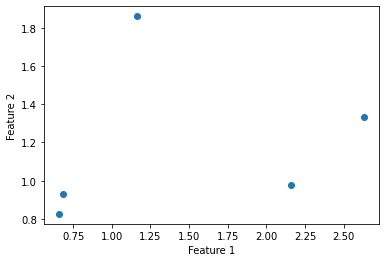

In [59]:
#generate stacked bar chart
%matplotlib inline
import matplotlib.pyplot as plt 

plt.scatter(px, py)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.savefig('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/Images/centres_explore_1.png')
plt.show()

In [60]:
#generate list of lists for each pathway => index, vector, cluster, score.
cost_vector = []
for i in range(num_reactions):
    cost_vector.append([i, rxn_vectors[i][1], labels[i], int_top_scores[i]])

In [23]:
check_one = [i[3] for i in cost_vector if (i[2] == 4)]
print(np.mean(check_one))

0.9008555555555554


In [38]:
#create dataframe with columns: pathway index, clusters, vector
indexes = list(np.arange(0,num_reactions))
vectors = [p[1] for p in rxn_vectors]
zero = [p[1][0] for p in rxn_vectors]
one = [p[1][1] for p in rxn_vectors]
two = [p[1][2] for p in rxn_vectors]
three = [p[1][3] for p in rxn_vectors]
cluster_labels = list(kmeans.labels_)

In [39]:
df_data = {
    'reaction_indx': indexes,
    'vectors': vectors,
    'zero': zero,
    'one': one,
    'two': two,
    'three': three,
    'clusters': cluster_labels
}

dataframe = pd.DataFrame(df_data, columns=list(df_data.keys()))

In [40]:
print(dataframe.head())

   reaction_indx                                            vectors  zero  \
0              0  [2, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...     2   
1              1  [0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...     0   
2              2  [0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...     0   
3              3  [0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...     0   
4              4  [0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...     0   

   one  two  three  clusters  
0    1    0      1         1  
1    0    1      0         0  
2    2    0      0         4  
3    2    0      0         4  
4    2    0      0         4  


C [1, 1, 1, 1, 2, 3, 3, 3, 4, 4]


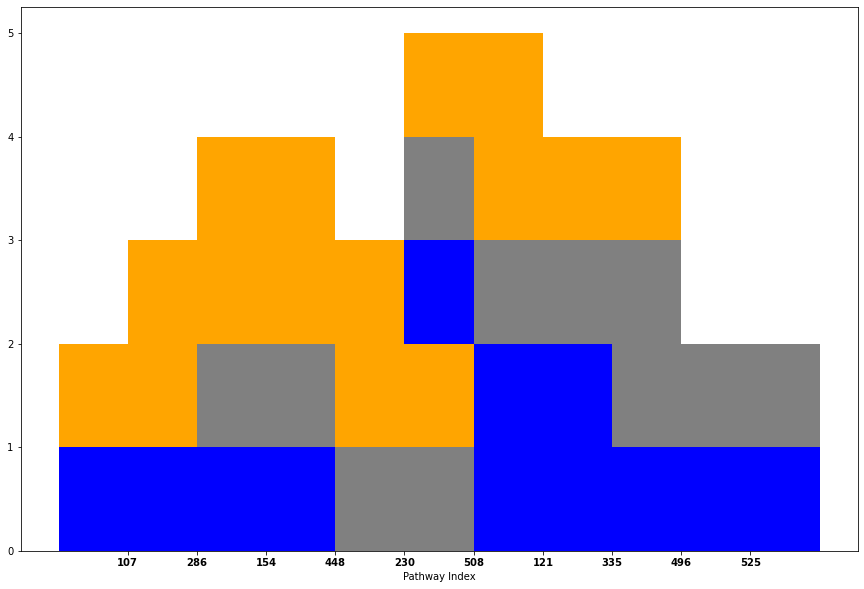

In [47]:
#generate stacked bar chart
%matplotlib inline
import matplotlib.pyplot as plt 

N = 10

random_df = dataframe.sample(n=N)
s_random_df = random_df.sort_values(['clusters'])


z = s_random_df['zero'].tolist()
o = s_random_df['one'].tolist()
t = s_random_df['two'].tolist()
th = s_random_df['three'].tolist()
c = s_random_df['clusters'].tolist()
print('C', c)

fig, ax = plt.subplots(1, figsize=(15, 10))

barst = np.add(z, o).tolist()
barsth = np.add(barst,t).tolist()

b = list(np.arange(0,N))
barwidth = 2
names = s_random_df['reaction_indx'].tolist()

plt.bar(b, z, color='blue', width=barwidth)
plt.bar(b,  o, bottom=z, color='grey', width=barwidth)
plt.bar(b, t, bottom=barst, color='green', width=barwidth)
plt.bar(b, th, bottom=barsth, color='orange', width=barwidth)

plt.xticks(b, names, fontweight='bold')
plt.xlabel("Pathway Index")


plt.show()

In [48]:
print('Number of molecules: ', len(solved_trees))
print('Number of reactions: ', num_reactions)


Number of molecules:  88
Number of reactions:  563


In [50]:
print(len(rxn_vectors))

563
